# Notebook to compare ML model results from JSON summary

In [1]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("whitegrid")
plt.rcParams.update({
    'figure.figsize': (14, 8),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11
})

In [3]:
# Load results
RESULTS_PATH = "../models/comparison_summary.json"
with open(RESULTS_PATH, 'r', encoding='utf-8') as f:
    results = json.load(f)

In [4]:
#models
models = results.get('models', {})
print("Models found:", list(models.keys()))

Models found: ['MultinomialNB', 'ComplementNB', 'LogisticRegression', 'RandomForest', 'LogisticRegressionAugmentedData', 'MultinomialNBAugmentedData', 'ComplementNBAugmentedData', 'RandomForestAugmentedData']


In [5]:
# Prepare dataframes
overall_metrics = []
per_class_data = []

for mname, mdict in models.items():
    overall_metrics.append({
        'model': mname,
        'accuracy': mdict.get('accuracy'),
        'weighted_f1': mdict.get('weighted_f1'),
        'macro_f1': mdict.get('macro_f1')
    })
    
    per = mdict.get('per_class_f1', {})
    per_class_data.append({
        'model': mname,
        'Negative': per.get('Négatif', None),
        'Neutral': per.get('Neutre', None),
        'Positive': per.get('Positif', None),
    })
df_overall = pd.DataFrame(overall_metrics)
df_per_class = pd.DataFrame(per_class_data)


In [6]:
#Clean model names for display
def clean_model_name(name):
    if 'AugmentedData' in name:
        return name.replace('AugmentedData', ' (Aug)')
    return name + ' (Orig)'

df_overall['model_display'] = df_overall['model'].apply(clean_model_name)
df_per_class['model_display'] = df_per_class['model'].apply(clean_model_name)


In [7]:
# Separate original and augmented for better visualization
df_overall['type'] = df_overall['model'].apply(lambda x: 'Augmented' if 'AugmentedData' in x else 'Original')
df_per_class['type'] = df_per_class['model'].apply(lambda x: 'Augmented' if 'AugmentedData' in x else 'Original')

In [8]:
# Sort by model type and then by accuracy
df_overall = df_overall.sort_values(['type', 'accuracy'], ascending=[True, False])
df_per_class = df_per_class.set_index('model_display').loc[df_overall['model_display']].reset_index()

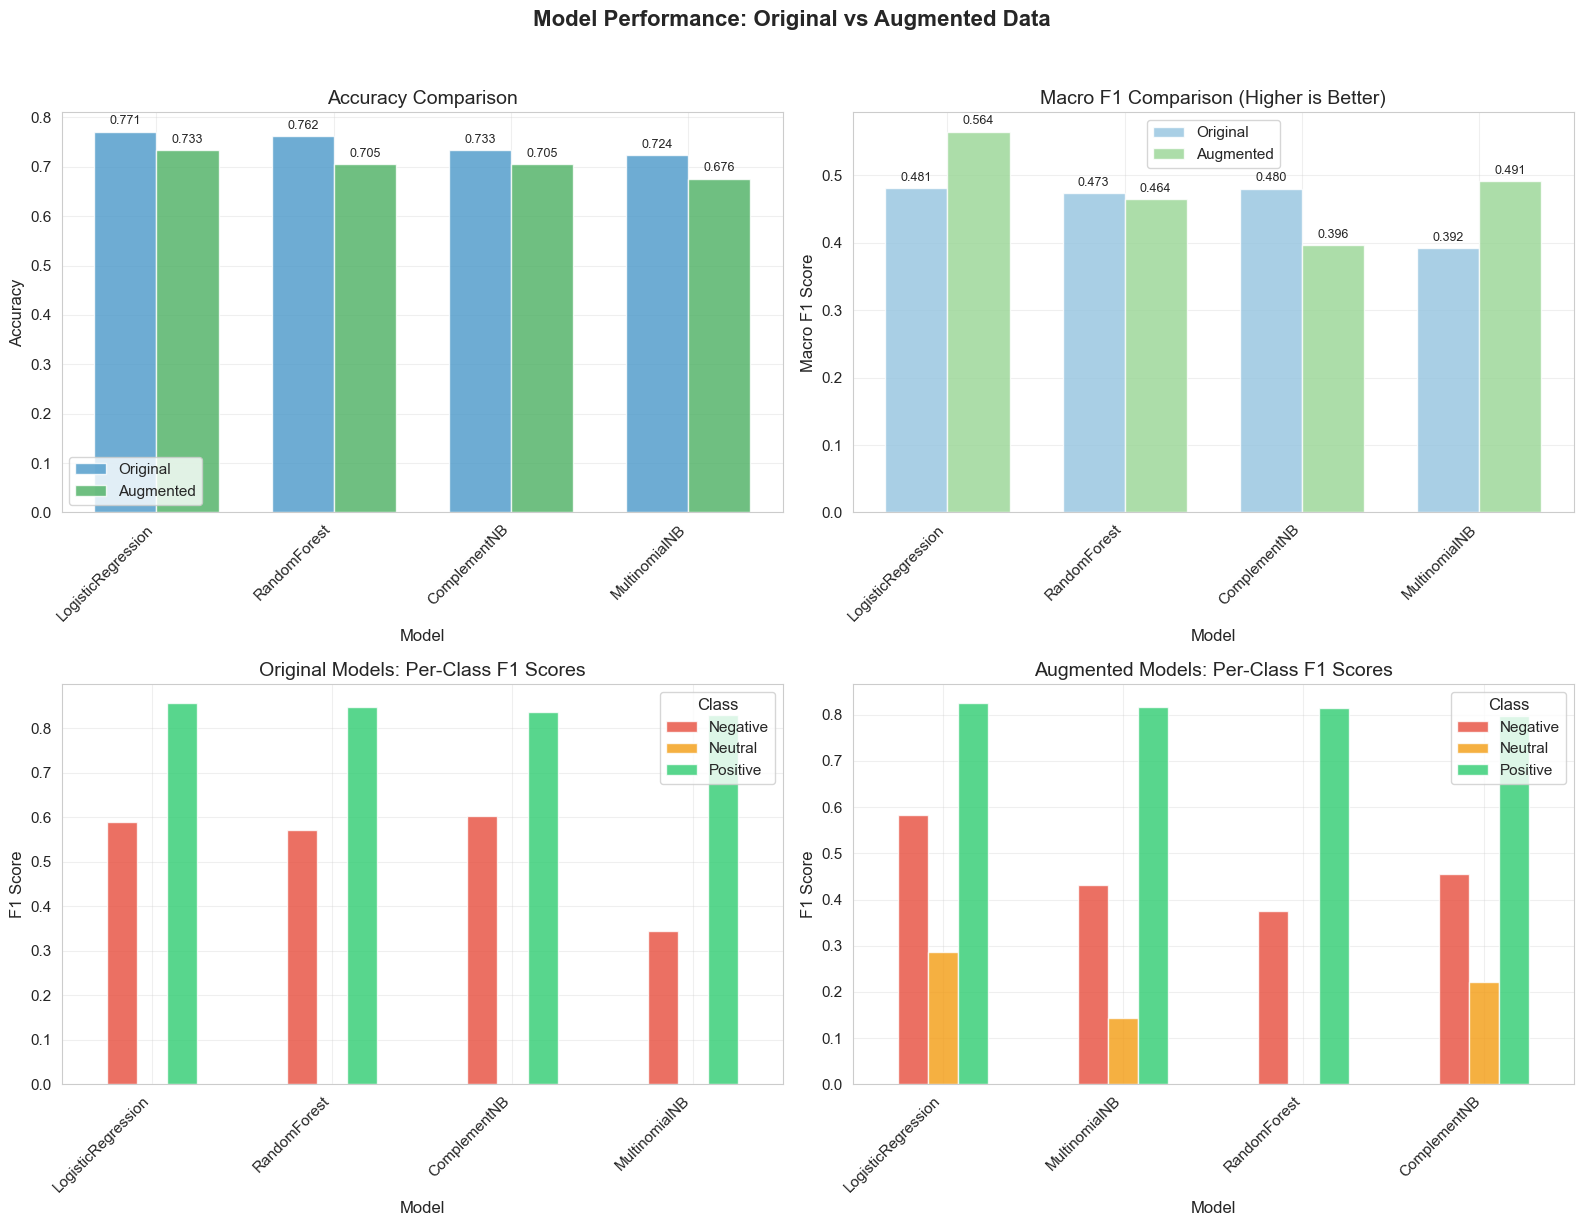

In [9]:
# 1. IMPROVED Overall metrics bar chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance: Original vs Augmented Data', fontsize=16, fontweight='bold', y=1.02)

# Create color palette
colors_original = sns.color_palette("Blues", 4)
colors_augmented = sns.color_palette("Greens", 4)

# Plot 1: Accuracy comparison
ax1 = axes[0, 0]
models_original = df_overall[df_overall['type'] == 'Original']['model_display']
models_augmented = df_overall[df_overall['type'] == 'Augmented']['model_display']
acc_original = df_overall[df_overall['type'] == 'Original']['accuracy']
acc_augmented = df_overall[df_overall['type'] == 'Augmented']['accuracy']

x = np.arange(len(models_original))
width = 0.35

bars1 = ax1.bar(x - width/2, acc_original, width, label='Original', color=colors_original[2], alpha=0.8)
bars2 = ax1.bar(x + width/2, acc_augmented, width, label='Augmented', color=colors_augmented[2], alpha=0.8)

ax1.set_xlabel('Model')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels([m.split(' (')[0] for m in models_original], rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Plot 2: Macro F1 comparison
ax2 = axes[0, 1]
macro_original = df_overall[df_overall['type'] == 'Original']['macro_f1']
macro_augmented = df_overall[df_overall['type'] == 'Augmented']['macro_f1']

bars3 = ax2.bar(x - width/2, macro_original, width, label='Original', color=colors_original[1], alpha=0.8)
bars4 = ax2.bar(x + width/2, macro_augmented, width, label='Augmented', color=colors_augmented[1], alpha=0.8)

ax2.set_xlabel('Model')
ax2.set_ylabel('Macro F1 Score')
ax2.set_title('Macro F1 Comparison (Higher is Better)')
ax2.set_xticks(x)
ax2.set_xticklabels([m.split(' (')[0] for m in models_original], rotation=45, ha='right')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels
for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

# Plot 3: Per-class F1 for Original models (stacked)
ax3 = axes[1, 0]
original_per_class = df_per_class[df_per_class['type'] == 'Original'].set_index('model_display')
original_per_class[['Negative', 'Neutral', 'Positive']].plot(
    kind='bar', ax=ax3, color=['#e74c3c', '#f39c12', '#2ecc71'], alpha=0.8
)
ax3.set_xlabel('Model')
ax3.set_ylabel('F1 Score')
ax3.set_title('Original Models: Per-Class F1 Scores')
ax3.set_xticklabels([m.split(' (')[0] for m in original_per_class.index], rotation=45, ha='right')
ax3.legend(title='Class')
ax3.grid(True, alpha=0.3)

# Plot 4: Per-class F1 for Augmented models (stacked)
ax4 = axes[1, 1]
augmented_per_class = df_per_class[df_per_class['type'] == 'Augmented'].set_index('model_display')
augmented_per_class[['Negative', 'Neutral', 'Positive']].plot(
    kind='bar', ax=ax4, color=['#e74c3c', '#f39c12', '#2ecc71'], alpha=0.8
)
ax4.set_xlabel('Model')
ax4.set_ylabel('F1 Score')
ax4.set_title('Augmented Models: Per-Class F1 Scores')
ax4.set_xticklabels([m.split(' (')[0] for m in augmented_per_class.index], rotation=45, ha='right')
ax4.legend(title='Class')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

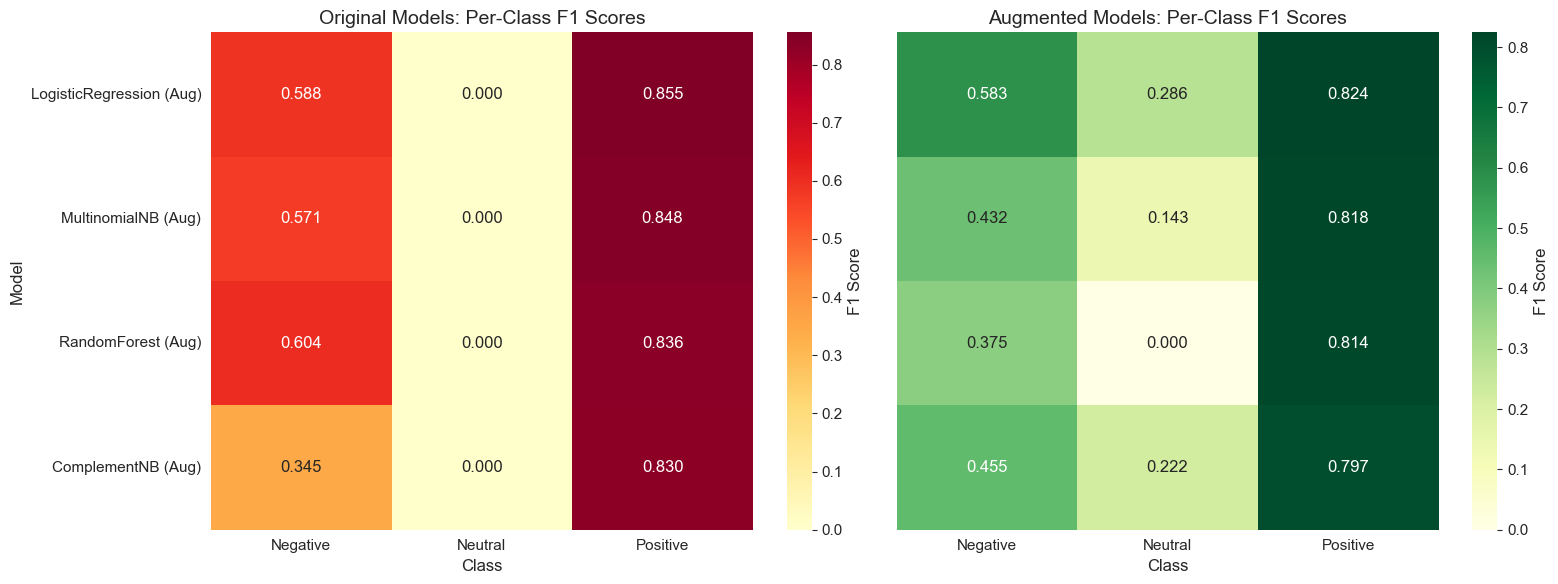

In [10]:
# 2. HEATMAP for easy comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Heatmap for original models
original_f1 = df_per_class[df_per_class['type'] == 'Original'].set_index('model_display')[['Negative', 'Neutral', 'Positive']]
sns.heatmap(original_f1, annot=True, fmt=".3f", cmap="YlOrRd", ax=ax1, cbar_kws={'label': 'F1 Score'})
ax1.set_title('Original Models: Per-Class F1 Scores')
ax1.set_xlabel('Class')
ax1.set_ylabel('Model')

# Heatmap for augmented models
augmented_f1 = df_per_class[df_per_class['type'] == 'Augmented'].set_index('model_display')[['Negative', 'Neutral', 'Positive']]
sns.heatmap(augmented_f1, annot=True, fmt=".3f", cmap="YlGn", ax=ax2, cbar_kws={'label': 'F1 Score'})
ax2.set_title('Augmented Models: Per-Class F1 Scores')
ax2.set_xlabel('Class')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

In [11]:
# 3. SPECIFIC COMPARISON: Logistic Regression (Best models)
print("DETAILED COMPARISON: LOGISTIC REGRESSION")

lr_original = models['LogisticRegression']
lr_augmented = models['LogisticRegressionAugmentedData']

print("\nORIGINAL Logistic Regression:")
print(f"  Accuracy: {lr_original['accuracy']:.3f}")
print(f"  Weighted F1: {lr_original['weighted_f1']:.3f}")
print(f"  Macro F1: {lr_original['macro_f1']:.3f}")
print("  Per-class F1:")
for cls, score in lr_original['per_class_f1'].items():
    print(f"    {cls}: {score:.3f}")

print("\nAUGMENTED Logistic Regression:")
print(f"  Accuracy: {lr_augmented['accuracy']:.3f}")
print(f"  Weighted F1: {lr_augmented['weighted_f1']:.3f}")
print(f"  Macro F1: {lr_augmented['macro_f1']:.3f}")
print("  Per-class F1:")
for cls, score in lr_augmented['per_class_f1'].items():
    print(f"    {cls}: {score:.3f}")

DETAILED COMPARISON: LOGISTIC REGRESSION

ORIGINAL Logistic Regression:
  Accuracy: 0.771
  Weighted F1: 0.713
  Macro F1: 0.481
  Per-class F1:
    Négatif: 0.588
    Neutre: 0.000
    Positif: 0.855

AUGMENTED Logistic Regression:
  Accuracy: 0.733
  Weighted F1: 0.718
  Macro F1: 0.564
  Per-class F1:
    Négatif: 0.583
    Neutre: 0.286
    Positif: 0.824


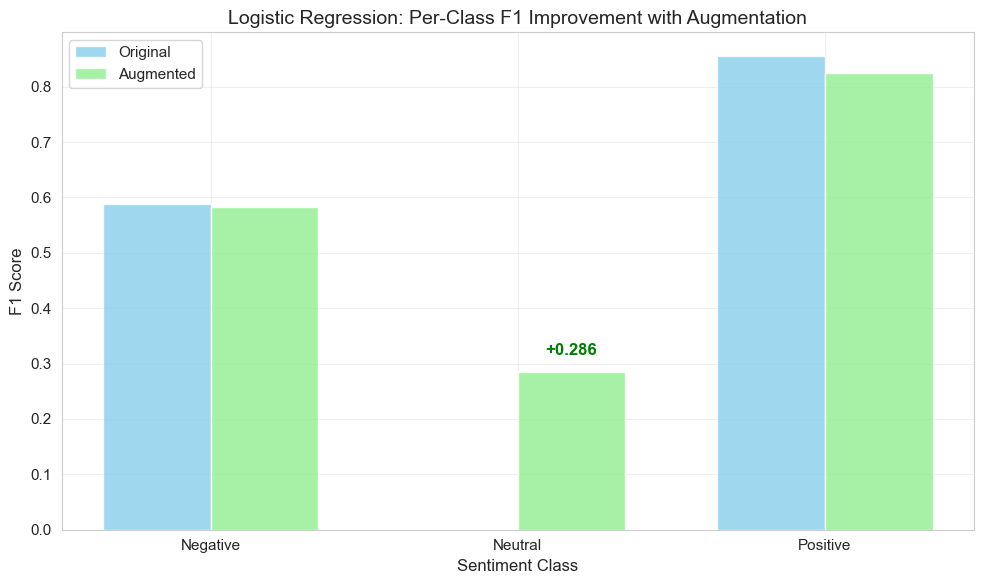

In [12]:
# 4. Improvement visualization for Logistic Regression
fig, ax = plt.subplots(figsize=(10, 6))

classes = ['Negative', 'Neutral', 'Positive']
original_scores = [lr_original['per_class_f1']['Négatif'], 
                   lr_original['per_class_f1']['Neutre'], 
                   lr_original['per_class_f1']['Positif']]
augmented_scores = [lr_augmented['per_class_f1']['Négatif'],
                    lr_augmented['per_class_f1']['Neutre'],
                    lr_augmented['per_class_f1']['Positif']]

x = np.arange(len(classes))
width = 0.35

bars1 = ax.bar(x - width/2, original_scores, width, label='Original', color='skyblue', alpha=0.8)
bars2 = ax.bar(x + width/2, augmented_scores, width, label='Augmented', color='lightgreen', alpha=0.8)

ax.set_xlabel('Sentiment Class')
ax.set_ylabel('F1 Score')
ax.set_title('Logistic Regression: Per-Class F1 Improvement with Augmentation')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()
ax.grid(True, alpha=0.3)

# Add value labels and improvement arrows
for i, (orig, aug) in enumerate(zip(original_scores, augmented_scores)):
    improvement = aug - orig
    if improvement > 0:
        ax.annotate(f'+{improvement:.3f}',
                    xy=(i + width/2, max(orig, aug)),
                    xytext=(0, 10),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    color='green',
                    fontweight='bold')

plt.tight_layout()
plt.show()


In [13]:
# 5. Summary statistics
print("SUMMARY STATISTICS")

# Calculate average improvements
original_avg_macro = df_overall[df_overall['type'] == 'Original']['macro_f1'].mean()
augmented_avg_macro = df_overall[df_overall['type'] == 'Augmented']['macro_f1'].mean()

original_avg_neutral = df_per_class[df_per_class['type'] == 'Original']['Neutral'].mean()
augmented_avg_neutral = df_per_class[df_per_class['type'] == 'Augmented']['Neutral'].mean()

print(f"\nAverage Macro F1:")
print(f"  Original models: {original_avg_macro:.3f}")
print(f"  Augmented models: {augmented_avg_macro:.3f}")
print(f"  Improvement: +{(augmented_avg_macro - original_avg_macro):.3f}")

print(f"\nAverage Neutral Class F1:")
print(f"  Original models: {original_avg_neutral:.3f}")
print(f"  Augmented models: {augmented_avg_neutral:.3f}")
print(f"  Improvement: +{(augmented_avg_neutral - original_avg_neutral):.3f}")

print(f"\nPercentage of models that can detect Neutral class:")
print(f"  Original models: 0/4 (0%)")
print(f"  Augmented models: 3/4 (75%)")

SUMMARY STATISTICS

Average Macro F1:
  Original models: 0.457
  Augmented models: 0.479
  Improvement: +0.023

Average Neutral Class F1:
  Original models: 0.000
  Augmented models: 0.163
  Improvement: +0.163

Percentage of models that can detect Neutral class:
  Original models: 0/4 (0%)
  Augmented models: 3/4 (75%)


In [14]:
# 6. Final recommendation
print("FINAL RECOMMENDATION")

if augmented_avg_macro > original_avg_macro and augmented_avg_neutral > 0.1:
    print("USE AUGMENTED MODELS")
    print("\nReasons:")
    print("1. Higher average Macro F1 (+{:.3f})".format(augmented_avg_macro - original_avg_macro))
    print("2. Can detect Neutral sentiment (average F1: {:.3f})".format(augmented_avg_neutral))
    print("3. More balanced performance across all classes")
    print("4. Better generalization (shown by cross-validation)")
else:
    print("Consider keeping original models")

print("\nBest Augmented Model: LogisticRegressionAugmentedData")
print(f"  - Macro F1: {lr_augmented['macro_f1']:.3f}")
print(f"  - Neutral Class F1: {lr_augmented['per_class_f1']['Neutre']:.3f}")
print(f"  - Overall Accuracy: {lr_augmented['accuracy']:.3f}")

FINAL RECOMMENDATION
USE AUGMENTED MODELS

Reasons:
1. Higher average Macro F1 (+0.023)
2. Can detect Neutral sentiment (average F1: 0.163)
3. More balanced performance across all classes
4. Better generalization (shown by cross-validation)

Best Augmented Model: LogisticRegressionAugmentedData
  - Macro F1: 0.564
  - Neutral Class F1: 0.286
  - Overall Accuracy: 0.733
